# Probability & Statistics Notes
_Ravi Dayabhai_

These are assorted "think aloud" notes I've taken while reviewing (and in some cases, learning anew!) some probability and statistics concepts in Spring/Summer 2021. The general structure (and content) follows MIT's OCW 18.05[1], but there are deviations based on my interests and the "holes" in my understanding that I wish to patch.

[1]: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import geom, norm
from scipy.special import comb

import matplotlib.pyplot as plt
from matplotlib import ticker

## Counting

Assume the traditional "Birthday problem" set up. Calculate the probability that some trio in a group of $n$ people have the same birthday.

In [3]:
# Define simulation
def birthday_triplet_sim(n: int, trials: int) -> float:
    trial_ct = 0
    success_ct = 0
    for _ in range(trials):
        trial_ct += 1
        group = np.random.randint(1, 365 + 1, n)
        (unique, counts) = np.unique(group, return_counts=True)
        if any(filter(lambda x: x >= 3, counts)):
            success_ct += 1
    return success_ct / trial_ct

What is minimum $n$ such that the probability of this event is at least $\frac{1}{2}$?

In [4]:
# Run 10k trials
trials = 10_000
experiments = 10
ns = [87, 88]

for n in ns:
    experiment_results = [birthday_triplet_sim(n, trials) for _ in range(experiments)]
    print(f"Average probability, {experiments} experiments: {np.mean(experiment_results)}")

Average probability, 10 experiments: 0.49845000000000006
Average probability, 10 experiments: 0.5084299999999999


## Distributions

### Geometric

Suppose that the inhabitants of an island plan their families by having babies until the first girl is born. Assume the probability of having a girl with each pregnancy is 0.5 independent of other pregnancies, that all babies survive and there are no multiple births. What is the probability that a family has $k$ boys?

In [5]:
# Geometric PDF (up to a point)
p = 0.5
loc = -1
for k in range(20 + 1):
    print(f"The probability of having {k} boys:", f"{geom.pmf(k, p, loc):.5f}")

The probability of having 0 boys: 0.50000
The probability of having 1 boys: 0.25000
The probability of having 2 boys: 0.12500
The probability of having 3 boys: 0.06250
The probability of having 4 boys: 0.03125
The probability of having 5 boys: 0.01562
The probability of having 6 boys: 0.00781
The probability of having 7 boys: 0.00391
The probability of having 8 boys: 0.00195
The probability of having 9 boys: 0.00098
The probability of having 10 boys: 0.00049
The probability of having 11 boys: 0.00024
The probability of having 12 boys: 0.00012
The probability of having 13 boys: 0.00006
The probability of having 14 boys: 0.00003
The probability of having 15 boys: 0.00002
The probability of having 16 boys: 0.00001
The probability of having 17 boys: 0.00000
The probability of having 18 boys: 0.00000
The probability of having 19 boys: 0.00000
The probability of having 20 boys: 0.00000


What about the ratio of boys to girls on the island?

In [6]:
# Expectation of Geometric distribution
geom.mean(p, loc)

1.0

### Runs

A run is a sequence of all $1$s or $0$s. For this problem, consider sequence of 50 Bernoulli random variables where $p = 0.5$.

In [7]:
def longest_runs_sim(n: int = 50) -> int:
    # Random sequence where each n_i is element of {0, 1}
    seq = np.random.randint(0, 1+1, n)
    longest_runs = {1: None, 0: None}
    for i, outcome in enumerate([~seq, seq]):
        runs = \
            np.diff( # Diff of indices counts runs
                np.where( 
                    np.concatenate( # Checks if next value is different; if yes, then 1
                        # Note: Concatenation deals with edge cases
                        ([outcome[0]], outcome[:-1] != outcome[1:], [True])
                    )
                )[0] # Returns indices for whenever value switches
            )[::2] # Only return the diffs for the 1s
        longest_runs[i] = runs.max()
    # Longest runs (0s or 1s) and sequence
    return max(longest_runs.values()), seq

What's the average length of a "longest run"?

In [8]:
# Calculate average longest run
trials = 10_000
results = []
for _ in range(trials):
    results.append(longest_runs_sim(50)[0])

# Longest runs average
sum(results) / len(results)

5.5429

If $Y$ the the length of the "longest run" in a series of $n=50$ fair coin flips, what is $P(Y \geq 8)$?

In [9]:
event_ct = 0
for _ in range(trials):
    if longest_runs_sim(50)[0] >= 8:
        event_ct += 1

# Estimate probability of a longest run in 50 flips >= 8
event_ct / trials

0.1324

## Continuous Distributions

### Standard Normal

Below, we practice computing probabilities using SciPy's standard normal class.

In [10]:
z_1 = 1.5
z_2 = -1
z_3 = 1

print(f"P(Z < {z_1}) = {round(norm.cdf(z_1), 3)}")
print(f"P({z_2} < Z < {z_3}) = {round(norm.cdf(z_3) - norm.cdf(z_2), 3)}")

P(Z < 1.5) = 0.933
P(-1 < Z < 1) = 0.683


The length of human gestation is well-approximated by a normal distribution with mean μ = 280 days and standard deviation σ = 8.5 days. Graph the PDF and CDF a random variable distributed according to this distribution.

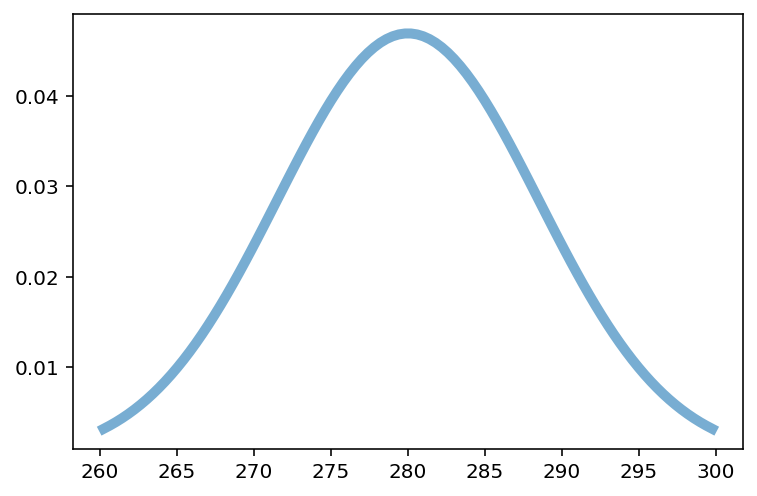

In [11]:
mu = 280
sigma = 8.5

z = np.linspace(norm.ppf(0.01), norm.ppf(.99), 100)
x = sigma * z + mu
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), lw=5, alpha=0.6, label='norm pdf')
plt.show()

The probability of giving birth μ-7 days or earlier assuming the above distribution is calculated as $P(X < \mu - 7)$.

In [12]:
norm.cdf(mu-7, loc=mu, scale=sigma)

0.2051034993461297

## Expectation & Variance (Univariate)

Suppose you are playing a game where you roll two dice. The payoff function can be described as:

$$
Y_{i, j} = ij - 10
$$

1. What's the expected payoff for this game? 
2. Is this a better game to play versus a game where you win \\$500 on rolling a 7 (this game sums the dice values) and lose \\$100 otherwise?

In [13]:
# Create two dice arrays
dice_1 = np.arange(1, 6+1)
dice_2 = dice_1.copy()

# Construct sample space, probability space, and outcomes
sample_space = np.array([np.tile(dice_1, len(dice_2)), 
                     np.repeat(dice_2, len(dice_1))])
rv_value = np.prod(sample_space, axis=0, keepdims=True) - 10
prob_distribution = np.full_like(rv_value, 1/sample_space.shape[1], dtype='float')

# Expected value of playing this dice game
expected_value = rv_value.dot(prob_distribution.transpose()).item(0)
expected_value

2.25

This is a better game than the alternative because the alternative's expected value is 0!

## Central Limit Theorem (CLT)

The centrality (🙃) of this theorem to statistics cannot be overstated. The CLT is useful for several reasons:

1. **Approximation**: The CLT allows us to approximate a sum or average of _any_ well-behaved (finite mean and variance) i.i.d random variables by a normal random variable. This is extremely useful because it is usually easy to do computations with the normal distribution.
2. **Inference**: This is what underprins frequentist null hypothesis testing.

### Binomial $\rightarrow$ Normal

Let's explore how, in the limiting case under special conditions, the Binomial approximates the Normal. The best conditions for this approximation are when $n$ is large and $p \approx 0.5$ (so that the Binomial random variable being approximated is somewhat symmetric).

#### Claim

Because $Y \sim \text{Bin}(n, p)$ can be expressed as $\sum_{i=1}^{n} X_{i}$ for $X_{i} \stackrel{\text{i.i.d.}}{\sim} \text{Bern}(p)$), we can use the Central Limit Theorem (CLT) provided that $n$ is sufficiently large. Specifically, the CLT tells us:

$$
\begin{align}
Z  &= \frac{Y - \mu_{Y}}{\sigma_{Y}} \stackrel{d}{\rightarrow} \mathcal{N}(0,1)\\
Z  &= \frac{Y - np}{\sqrt{npq}}\\
\end{align}
$$

To adjust for discrete vs. continuous contexts, we can use a _continuity correction_ when approximating $P(Y=k)$:

$$
P(Y = k) = P\left(k - \frac{1}{2} < Y < k + \frac{1}{2}\right)
$$

#### Justification

Notice that getting from the above to a more familiar incarnation of the CLT for a Bernoulli random variable $X$ is just a matter of transforming $Y$; said another way, $\frac{Y}{n} = \bar{X_{n}}$ is a sampled mean and we know that the sampling distribution of the sample mean is Normal.

$$
\begin{align}
\frac{Y}{n} = \bar{X_{n}} \implies Z &= \frac{\frac{Y}{n} - \mu_{\bar{X_{n}}}}{\sigma_{\bar{X_{n}}}} \stackrel{d}{\rightarrow} \mathcal{N}(0,1)\\
Z  &= \sqrt{n}\frac{\bar{X_{n}} - p}{\sqrt{pq}} = \sqrt{n}\frac{\hat{p_{n}} - p}{\sqrt{pq}}\\
\end{align}
$$

So, to get from the bottom relationship to the top we can simply multiply the numerator and denominator on the right-hand side by $n$!

### Poisson → Normal

Similarly, we can leverage what we know about the sum of independent Poissons to arrive at a similar conclusion about the average of many i.i.d Poissons!

#### Claim & Justification

Let $Y \sim \text{Pois}(n)$. We know that the sum of independent Poissons is Poisson (e.g., counting green cars ($\lambda_{1}$) and blue cars ($\lambda_{2}$) is the same thing as counting blue or green cars over the same period ($\lambda = \lambda_{1} + \lambda_{2}$)). Therefore, we can let $Y = \sum_{i=1}^{n} X_{i}$, where $X \sim \text{Pois}(1)$. Immediately, by the CLT and that the Poisson has special property that its mean and variance are the same: 

$$
Y \sim \mathcal{N}(n, n)
$$

## Hypothesis Testing

### $p$-values $\dot\sim \text{Unif}(0, 1)$

**Upshot**: When samples come from the same distribution, the $p$-values are distributed normally.

This might seem surprising, but it reminds us of the "Universality of the Uniform".[1] [2] Basically, the survival function $G(x) = 1-F(x)$ for $X \sim \mathcal{N}(\mu, \sigma^{2})$ is the function of $x$ that returns a the $p$-value. (Here, $X$ is the sample statistic, itself a random variable which is distributed normally by the CLT.)

But we know from the "Universality of the Uniform" that when we plug $X$ into its CDF, we get a standard normal. This is easily proven below:

_Proof_: Universality of the Uniform

Let $X$ have CDF $F$. Find the CDF of $Y = F(X)$. Since $Y$ takes on values in $(0,1)$, for $y \in (0,1)$,

$$
\begin{align}
P(Y \leq y) &= P(F(X) \leq y) = P(F^{-1}(F(X)) \leq F^{-1}(y)) = P(X \leq F^{-1}(y))\\
&= F(F^{-1}(y)) = y.
\end{align}
$$

Thus, $Y \sim \text{Unif}(0,1)$.

By symmetry (because $X$ is normally distributed), we can use substitute $F$ with $G$, so $Y$ is a random value of $p$-values, and we see that $Y$ is distributed standard uniform.

We can also simulate this fact, which I do below:


[1]: https://en.wikipedia.org/wiki/Probability_integral_transform
[2]: https://www.youtube.com/watch?v=TzKANDzAXnQ

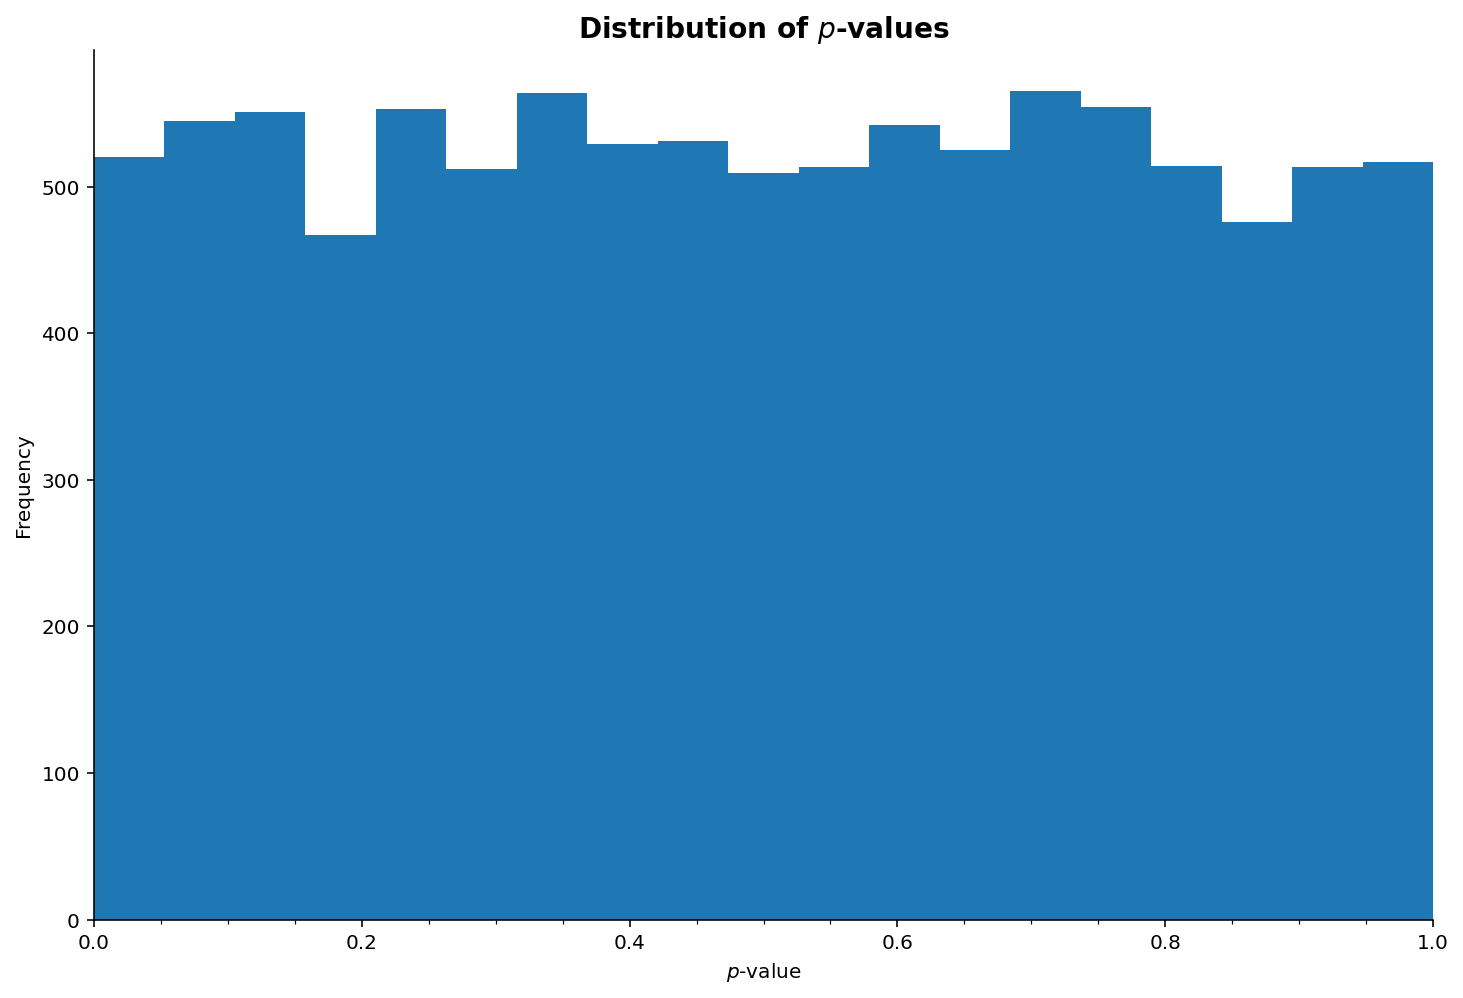

In [14]:
# Draw N times from normal distribution; each draw is a realized sample statistic
# Note: Assuming standard normal for convenience
N = 10_000
samples = np.random.normal(0, 1, N)
p_values = norm.sf(samples)

# Plot distribution of p-values
plt.figure(figsize=(12,8))
bins = np.linspace(0, 1, 20, endpoint=True)
plt.hist(p_values, bins=bins)

# Cosmetic
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.xlim(left=0, right=1)
plt.xlabel('$p$-value')
plt.ylabel('Frequency')
plt.title('Distribution of $p$-values', fontsize=14, fontweight='bold')

# Show plote
plt.show()

Thinking about hypothesis testing, fundamentally, we are interested in whether a Treatment effect exists. Said another way, are Treated samples coming from a different sampling distribution?

When the distributions are different, we expect skew in the distribution of $p$-values. StatQuest has [a fantastic video](https://www.youtube.com/watch?v=K8LQSvtjcEo) recapping these ideas in relation to controlling the false discovery rate (in the context of multiple hypothesis testing; see explanation below).

### Multiple Comparisons/Tests Problem

Multiple comparisons arise when a statistical analysis involves multiple simultaneous statistical tests, each of which has a potential to produce a "discovery", of the same dataset or dependent datasets. A stated confidence level generally applies only to each test considered individually, but often it is desirable to have a confidence level for the whole family of simultaneous tests.[1]

Consider the example of an A/A test (so there is no real Treatment effect) where there are 100 independent metrics being tested. Then the probability of a spurious false positive or "discovery" when there is truly not one to be had is deduced as:

$$
\begin{align}
P(\text{at least one significant result}) &= 1 - P(\text{no significant results})\\
&= 1 - (1 - \alpha_{\text{per comparison}})^{100}
\end{align}
$$

Assuming $\alpha_{\text{per comparison}} = 0.05$, this yields a startling conclusion:

$$
\begin{align}
P(\text{at least one significant result}) &= 1 - (0.95)^{100}\\
&\approx 0.994
\end{align}
$$

With $99.4\%$ probability there will be at least one test that will falsely reject the null hypothesis (due to random [sampling error](https://en.wikipedia.org/wiki/Sampling_error))! This is called the _family-wise error rate_, $\alpha$ for $m$ independent comparisons.

The next few sections will demonstrate a few approaches to correcting for this problem.

[1]: https://en.wikipedia.org/wiki/Multiple_comparisons_problem

#### Correcting Multiple Comparisons

To illustrate each of the following techniques, let's set up some dummy data to see the effect of each correction. (_Credit_: Megan Goldman's [notes](https://www.stat.berkeley.edu/~mgoldman/Section0402.pdf) served as the motivation for this; the examples herein are the same as hers, save for being ported to Python.)

In [15]:
# Let's simulate 900 draws from a standard normal 
mu_0, sigma_0 = 0, 1
n_0 = 900
null_true_outcomes = np.random.normal(mu_0, sigma_0, n_0)

# ...and 100 draws from a normal with mean = 3 and variance = 1
mu_1, sigma_1 = 3, 1
n_1 = 100
null_false_outcomes = np.random.normal(mu_1, sigma_1, n_1)

# To align my notation with that of the Wikipedia article
m = (n_0 + n_1)

In [16]:
# P(Type I Error) when null hypothesis (e.g., 0 difference in means) is TRUE
alpha = 0.05
(norm.sf(null_true_outcomes, loc=mu_0, scale=sigma_0) < alpha).mean()

0.04888888888888889

In [17]:
# 1 - P(Type II Error) when null hypothesis (e.g., 0 difference in means) is FALSE
alpha = 0.05
(norm.sf(null_false_outcomes, loc=mu_0, scale=sigma_0) < alpha).mean()

0.95

Okay, so we see that $\alpha$ makes sense ($\approx 5\%$) and that we have good power ($\approx 90\%$) when the $H_{0}$ is indeed false.

##### Bonferroni Correction

This makes the significance level more stringent for each test:

$$
\alpha_{\text{per comparison}} = \frac{\alpha}{n}
$$

The nice thing about this simple heuristic is that it is free from distributional or independence assumptions.

Remember, though, there is no such thing as a free lunch! **Because we've reduced the $P(\text{Type I error})$, the Faustian bargain is borne out by reduced power** (i.e., $\uparrow \beta$, or a higher false negative rate)!

Let's see how this fares when applied to our cooked up data.

In [18]:
# Apply the Bonferroni correction on our data
alpha_per_comparison = 0.05 / m
(norm.sf(null_true_outcomes, loc=mu_0, scale=sigma_0) < alpha_per_comparison).mean()

0.0

We've really squeezed out a ton of Type I error by applying this correction, but the other shoe is about to drop:

In [19]:
# Apply the Bonferroni correction on our data
alpha_per_comparison = 0.05 / m
(norm.sf(null_false_outcomes, loc=mu_0, scale=sigma_0) < alpha_per_comparison).mean()

0.22

We've eviscerated our power!

_Note_: The **Šidák correction** is a variation on this theme. It uses a marginally less conservative method of controlling the _family-wise error rate_ (i.e., probability of at least 1 false positive, $\alpha$). This correction assumes the tests are independent because this procedure simply solves for $\alpha_{\text{per comparison}}$ using the equation we used to demonstrate the multiple comparisons problem in the first place.

Connecting those dots more explicitly, this:

$$
\alpha_{\text{per comparison}} = 1 - (1 - \alpha)^{\frac{1}{m}}
$$

...is simply the below, algebraically rearranged: 

$$
\begin{align}
P(\text{at least one significant result}) &= 1 - P(\text{no significant results})\\
\alpha &= 1 - (1 - \alpha_{\text{per comparison}})^{m}
\end{align}
$$

Notice the "reduced" discount to $\alpha$ is related to the inequality of arithmetic and geometric means[1].

[1]: https://en.wikipedia.org/wiki/Inequality_of_arithmetic_and_geometric_means

In [20]:
# Apply the Šidák correction on our data
alpha_per_comparison = 1 - (1 - 0.05) ** (1/m)
(norm.sf(null_true_outcomes, loc=mu_0, scale=sigma_0) < alpha_per_comparison).mean()

0.0

In [21]:
# Apply the Šidák correction on our data
alpha_per_comparison = 1 - (1 - 0.05) ** (1/m)
(norm.sf(null_false_outcomes, loc=mu_0, scale=sigma_0) < alpha_per_comparison).mean()

0.23

##### Controlling False Discovery Rate (FDR)

FDR-controlling procedures provide less stringent control of Type I errors compared to family-wise error rate controlling procedures (e.g., Bonferroni correction), which control the probability of _at least one_ Type I error. Thus, **FDR-controlling procedures have greater power, at the cost of increased numbers of Type I errors.**[1]

[1]: https://en.wikipedia.org/wiki/False_discovery_rate

The **Benjamini–Hochberg procedure** implements this idea. This is valid when the $m$ tests are independent, and also in various scenarios of dependence, but is _not_ universally valid.[1]

For the FDR, we want to consider the ordered $p$-values. We will find the largest $k$th ordered $p$-value
that is less than or equal to $\frac{k\times\alpha}{m}$ and use this "boundary" $p$-value as our $\alpha_{\text{per comparison}}$.

Importantly, let's clarify the terminology which can get quite confusing in what might already appear to be a confusing undertaking.

- The False Discovery Rate (FDR) is the proportion of false positives among _all statistically significant tests_.
- $1 - \text{FDR}$ here is akin to a "precision" metric: "Of the tests we deem statistically significant, how many actually are?"
- $\alpha$ in this context is redefined to be the upper bound, in expectation, for the FDR we desire.
- Importantly, $\alpha \neq \alpha_{\text{per comparison}}$!

If the explanation below, doesn't suffice, this deck[2] from the Department of Statistics and Applied Probability does a superb job of explaining the what and why of this method.

[1]: http://www.math.tau.ac.il/~ybenja/MyPapers/benjamini_yekutieli_ANNSTAT2001.pdf
[2]: https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/0/3425/files/2018/10/Understanding-Benjamini-Hochberg-method-2ijolq0.pdf

In [22]:
# Concatenate original outcome arrays and convert to p-values
all_outcomes = np.concatenate((norm.sf(null_true_outcomes, loc=mu_0, scale=sigma_0), 
                               norm.sf(null_false_outcomes, loc=mu_0, scale=sigma_0)))
all_outcomes_argsorted = np.argsort(all_outcomes)

# Get the largest kth ordered p-value less than BH condition ("boundary" p-value)
all_outcomes_sorted = np.sort(all_outcomes)

# k is 1-indexed
k = np.argsort(all_outcomes_sorted) + 1
bh_condition = all_outcomes_sorted <= (k * 0.05 / m)
largest_k = bh_condition.sum()

Notice that this method produces a much less conservative $\alpha_{\text{per comparison}}$ than the Bonferroni correction!

In [23]:
# Index into the "boundary" p-value = alpha_per_comparison
alpha_per_comparison = all_outcomes_sorted[largest_k-1]
alpha_per_comparison

0.0032162915528709795

**Note**: Some sources might, rather than adjust the significance level _per comparison_ to the computed figure above, adjust the $p$-values (called $q$-values in the literature) while keeping $\alpha$ intact. Mathemetically, these are equivalent procedures:

- Method 1: Adjust the significance level _per comparison_

1. First determine the "boundary" $p$-value, i.e., the largest $P_{(k)}$ where $P_{(k)} \leq \frac{k \alpha}{m}$.
2. Deem statistical significance if a given test has a $p$-value $< P_{(k)}$.


- Method 2: Adjust the $p$-values (called $q$-values)

1. Scale $p$-values into $q$-values, i.e., $Q_{(k)} = \frac{mP_{(k)}}{k}$
2. Deem statistical significance if a given test has a $q$-value $< \alpha$, i.e., $Q_{(k)} < \alpha$.

**Moral**: Some people use $Q$ while others use $\alpha$ when referring to the desired ceiling (in expectation) for the false discovery rate.


"Much less conservative" simply means that the $\alpha_{\text{per comparison}}$ (above) is greater than the case where we applied Bonferroni procedure:

In [24]:
# Bonferroni-corrected alpha
alpha / m

5e-05

We're not making a statement about the probability of having _at least_ one false positive (i.e., family-wise error rate) _among all tests_. Instead we're accepting that there will be false positives; our intention is to try to curtail the frequency with which they appear _among the tests we deem statistically significant_!

To show that we haven't really moved the needle in terms of FWER-$\alpha$:

In [25]:
# Calculate FWER
fwer_alpha = 1 - (1 - alpha_per_comparison) ** m
fwer_alpha

0.9601038294431766

The big idea is that we want our false discovery rate to be bounded, on average, by the stated $\alpha$: i.e., on average, FDR $\leq \alpha$ (even if this particular instance might not strictly adhere to this inequality).

In [26]:
# Get the tests that we declare significant based on "boundary" p-value = alpha_per_comparison
stat_sig_tests = all_outcomes_argsorted[:largest_k]

# Calculate FDR, which, on average will be less than alpha
(stat_sig_tests < len(null_true_outcomes)).sum() / len(stat_sig_tests)

0.06060606060606061

In general, the above will result in a value less than the upper bound on the FDR we wanted, i.e., $\alpha$.

Now, we with the indices / specific declared significant tests, we can compare this procedure's corrective consequences to the Bonferroni correction above:

In [27]:
# Power = 1 - beta
(stat_sig_tests >= len(null_true_outcomes)).sum() / len(null_false_outcomes)

0.62

Just of curiousity, let's see the proportion of Type I errors in the case where the null hypothesis was true:

In [28]:
# P(Type I error)
(stat_sig_tests < len(null_true_outcomes)).sum() / len(null_true_outcomes)

0.0044444444444444444

Geometrically, this corresponds to plotting $P_{(k)}$ vs. $k$, drawing the line through the origin with slope $\frac {\alpha}{m}$, and declaring discoveries for all points on the left up to and including the last point that is below the line.[1] Luckily, we've already done all the heavy-lifting.

[1]: https://en.wikipedia.org/wiki/False_discovery_rate

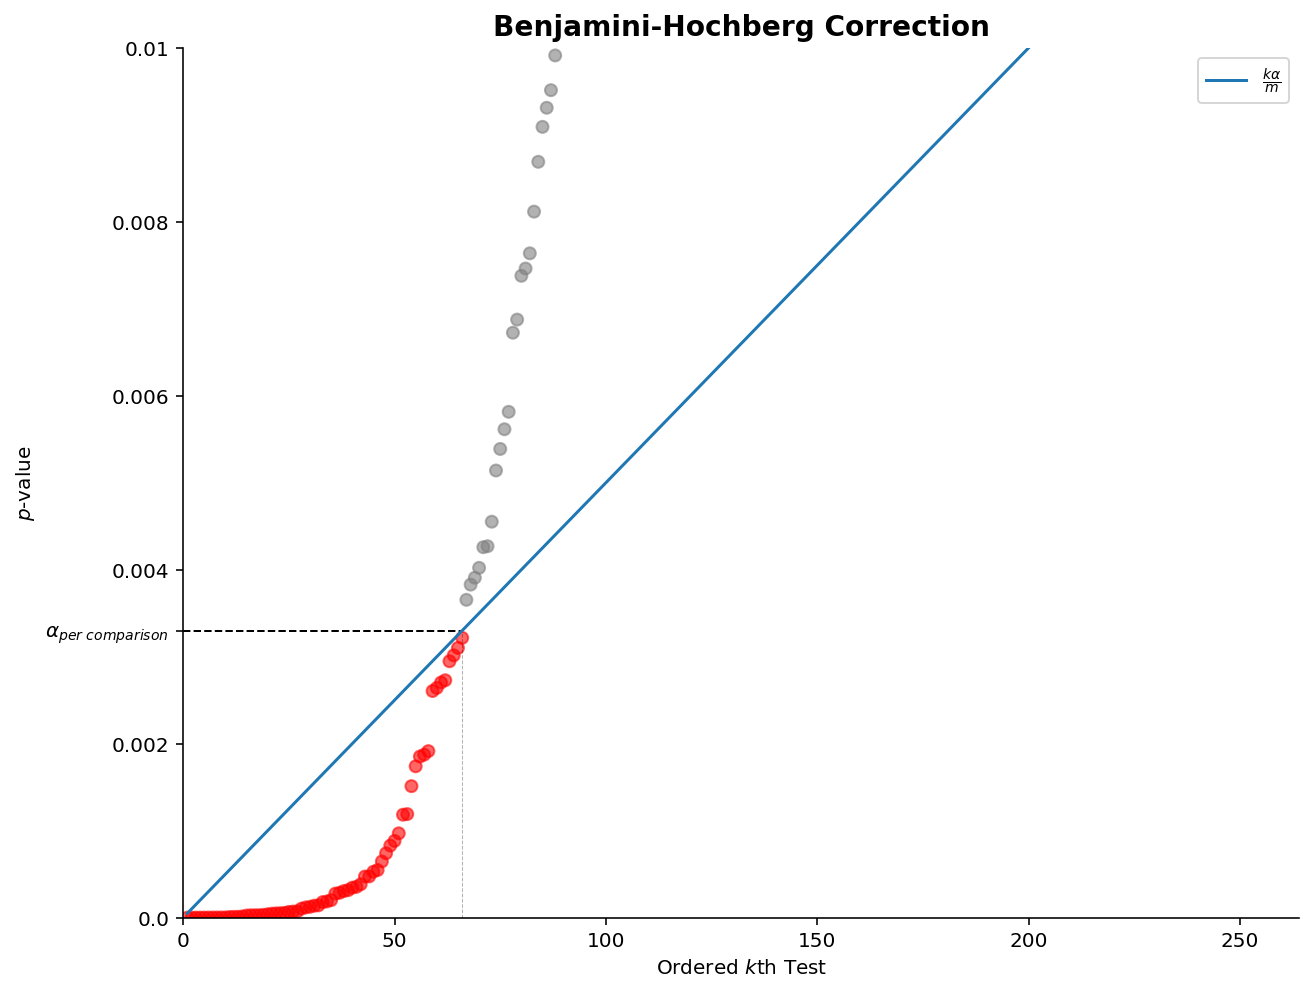

In [32]:
# Organize our data for the plot
x = k
y = all_outcomes_sorted
bh_line = x * alpha / m

# Conditional colors
color = np.where(y < bh_line, 'r' , 'grey')

# Plot data
plt.figure(figsize=(10,8))
plt.scatter(x, y, c=color, alpha=0.6, edgecolors=None)
plt.plot(x, bh_line, label=r'$\frac{k \alpha}{m}$')
plt.vlines(largest_k, 0, (largest_k + 0.5) * alpha / m, 
           linestyle="dashed", lw=0.5, color='k', alpha=0.3)
plt.hlines((largest_k) * alpha / m, 0, largest_k, 
           linestyle="dashed", lw=1, color='k')

# Cosmetic tweaks
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(left=0, right=largest_k * 4)
plt.ylim(bottom=0, top = .01)
plt.ylabel('$p$-value')
plt.xlabel('Ordered $k$th Test')
plt.title('Benjamini-Hochberg Correction', fontsize=14, fontweight='bold')

# Identify "boundary" p-value
y_ticks = ax.get_yticks() 
y_ticks = np.append(y_ticks, largest_k * alpha / m)
y_ticks_lst = y_ticks.tolist()
y_ticks_lst[-1]= "$\\alpha_{per\ comparison}$"
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lst)

# Show plot
plt.legend()
plt.show()

### Class Imbalance Problem

This problem is when the ratio of units in the Control (A) vs. Treatment (B) begins to stray away from 1 (50/50 split).